In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW
from transformers import BertForSequenceClassification
import random

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from pandarallel import pandarallel
pandarallel.initialize()

import os
os.chdir('..')

from src.data_lexical import LexDataset, read_lexical_corpus
from src.model import BertForSharedTaskBaseline
from src.training import train, evaluate, forward_func_custom_bert

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [3]:
epochs = 20
seed_val = 2
results_window = {}
max_len = 25
stop_at = 5
cuda_card = 0

In [7]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

for window_x in [0, 1, 2]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions = read_lexical_corpus('data/raw/lcp_single_train.tsv',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    test_texts, _, test_labels, sentences_test, test_target_words, test_positions = read_lexical_corpus('data/raw/lcp_single_trial.xlsx',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    torch.cuda.manual_seed_all(seed_val)

    train_index, val_index = train_test_split(list(range(0, len(data_texts))), test_size=0.12, random_state=10, shuffle=True)
    train_index, val_index = np.array(train_index), np.array(val_index)
    
    history_preds_val = []
    history_preds_test = []
    history_samples_val = []
    history_samples_test = []
    history_input = []
    history_input_test = []
    history_target = []
    history_target_test = []
    history_index = []
    history_labels_val = []
    history_labels_test = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    #val_index = np.load('val_tmp.npy')
    #train_index = np.load('train_tmp.npy')

    train_texts, train_labels, train_positions, train_target_words = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index]
    val_texts, val_labels, val_positions, val_target_words = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index]

    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
    train_dataset = LexDataset(train_encodings, train_labels, train_positions)
    train_loader = DataLoader(train_dataset, batch_size=16)

    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
    val_dataset = LexDataset(val_encodings, val_labels, val_positions)
    val_loader = DataLoader(val_dataset, batch_size=1)
    
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)
    test_dataset = LexDataset(test_encodings, test_labels, test_positions)
    test_loader = DataLoader(test_dataset, batch_size=1)
        
    all_text = ' '.join(train_texts)
    occurence_text = [all_text.count(w) for w in val_target_words]
        
    occurence_target = [train_target_words.tolist().count(w) for w in val_target_words]
        
    device = torch.device(f"cuda:{cuda_card}")
        
    model = BertForSharedTaskBaseline.from_pretrained(
        "bert-base-uncased", 
        num_labels = 1, 
        output_attentions = False, 
        output_hidden_states = False, 
    )
    model.cuda(cuda_card)

    optimizer = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
        
    tracking_metrics_val = []
    tracking_logits_val = []
    
    tracking_metrics_test = []
    tracking_logits_test = []
    
    early_stopping = 0
    best_metric = 1000000
        
    for epoch_i in range(0, epochs):
        print()
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        train(device, model, train_loader, forward_func_custom_bert, optimizer, scheduler)
        
        _, val_logits, val_metric = evaluate(device, model, val_loader, forward_func_custom_bert)
        _, test_logits, test_metric = evaluate(device, model, test_loader, forward_func_custom_bert)

        tracking_metrics_val.append(val_metric)
        tracking_logits_val.append(val_logits)
        
        tracking_metrics_test.append(test_metric)
        tracking_logits_test.append(test_logits)
        
        if val_metric > best_metric:
            early_stopping += 1
        else:
            best_metric = val_metric
            early_stopping = 0
                
        if early_stopping == stop_at:
            break
            
        index_min = np.argmin(tracking_metrics_val)
            
    history_labels_val.extend(val_labels)
    history_labels_test.extend(test_labels)
    history_preds_val.extend(tracking_logits_val[index_min])
    history_preds_test.extend(tracking_logits_test[index_min])
    history_samples_val.extend(val_texts)
    history_samples_test.extend(test_texts)
    history_input.extend(sentence_raw[val_index])
    history_input_test.extend(sentences_test)
    history_target.extend(target_words[val_index])
    history_target_test.extend(test_target_words)
    history_index.extend(([ix_fold] * len(val_index)))
    history_occur_text.extend(occurence_text)
    history_occur_target.extend(occurence_target)
    ix_fold += 1

    print("")
    print("Training complete!")
        
    del model
    torch.cuda.empty_cache()
        
    results_val = pd.DataFrame()
    results_val['samples'] = history_samples_val
    results_val['preds'] = history_preds_val
    results_val['true'] = history_labels_val
    results_val['raw'] = history_input
    results_val['raw'] = results_val['raw'].astype(str)
    results_val['target'] = history_target
    results_val['index'] = history_index
    results_val['occur_text'] = history_occur_text
    results_val['occur_target'] = history_occur_target
    results_val['particion'] = 'val'
    
    results_test = pd.DataFrame()
    results_test['samples'] = history_samples_test
    results_test['preds'] = history_preds_test
    results_test['true'] = history_labels_test
    results_test['raw'] = history_input_test
    results_test['raw'] = results_test['raw'].astype(str)
    results_test['index'] = 0
    results_test['target'] = history_target_test
    results_test['particion'] = 'test'

    results = pd.concat((results_val, results_test), axis=0)
    results_window[window_x] = results

Window size of  0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.015367

Running Validation...
  Metric: 0.064109
  Validation Loss: 0.006605

Running Validation...
  Metric: 0.076020
  Validation Loss: 0.010005

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.008385

Running Validation...
  Metric: 0.062791
  Validation Loss: 0.006514

Running Validation...
  Metric: 0.078080
  Validation Loss: 0.011341

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.006954

Running Validation...
  Metric: 0.059973
  Validation Loss: 0.005871

Running Validation...
  Metric: 0.073110
  Validation Loss: 0.009652

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006074

Running Validation...
  Metric: 0.059338
  Validation Loss: 0.005667

Running Validation...
  Metric: 0.073010
  Validation Loss: 0.009413

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005752

Running Validation...
  Metric: 0.060507
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.016464

Running Validation...
  Metric: 0.067459
  Validation Loss: 0.007507

Running Validation...
  Metric: 0.079905
  Validation Loss: 0.011648

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.008710

Running Validation...
  Metric: 0.069711
  Validation Loss: 0.007986

Running Validation...
  Metric: 0.084359
  Validation Loss: 0.013303

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.006826

Running Validation...
  Metric: 0.063785
  Validation Loss: 0.006674

Running Validation...
  Metric: 0.076297
  Validation Loss: 0.010866

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006080

Running Validation...
  Metric: 0.067633
  Validation Loss: 0.007426

Running Validation...
  Metric: 0.080990
  Validation Loss: 0.012091

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005246

Running Validation...
  Metric: 0.064691
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.018929

Running Validation...
  Metric: 0.077649
  Validation Loss: 0.010206

Running Validation...
  Metric: 0.090973
  Validation Loss: 0.014849

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.010044

Running Validation...
  Metric: 0.072983
  Validation Loss: 0.008912

Running Validation...
  Metric: 0.087861
  Validation Loss: 0.014137

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.007754

Running Validation...
  Metric: 0.067885
  Validation Loss: 0.007732

Running Validation...
  Metric: 0.078567
  Validation Loss: 0.011535

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.005876

Running Validation...
  Metric: 0.071077
  Validation Loss: 0.008305

Running Validation...
  Metric: 0.085696
  Validation Loss: 0.013765

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.004915

Running Validation...
  Metric: 0.067179
  V

In [8]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    

In [9]:
for window_ix in results_window:
    print('Window of', window_ix)
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Valid:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Test:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    #print('R2  --- Mean:', round(np.mean(r_2), 4), ' Std:', round(np.std(r_2), 4))
    print()


Window of 0
Valid:
MAE --- Mean: 0.0593  Std: 0.0
MSE --- Mean: 0.0057  Std: 0.0
Test:
MAE --- Mean: 0.073  Std: 0.0
MSE --- Mean: 0.0094  Std: 0.0

Window of 1
Valid:
MAE --- Mean: 0.0638  Std: 0.0
MSE --- Mean: 0.0067  Std: 0.0
Test:
MAE --- Mean: 0.0763  Std: 0.0
MSE --- Mean: 0.0109  Std: 0.0

Window of 2
Valid:
MAE --- Mean: 0.0672  Std: 0.0
MSE --- Mean: 0.0076  Std: 0.0
Test:
MAE --- Mean: 0.0815  Std: 0.0
MSE --- Mean: 0.0125  Std: 0.0



In [10]:
import spacy

nlp = spacy.load("en_core_web_sm")
def find_pos(sentence, ref):
    try:
        doc = nlp(sentence)
        for token in doc:
            if token.text == ref:
                return token.pos_
        return np.nan            
    except:
        return np.nan

In [11]:
for window_ix in results_window:
    print(window_ix)
    results_window[window_ix]['pos_label'] =  results_window[window_ix].apply(lambda x: find_pos(x.raw, x.target), axis=1)
    

0
1
2


Window size of: 0


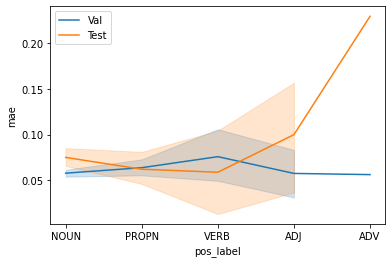

Window size of: 1


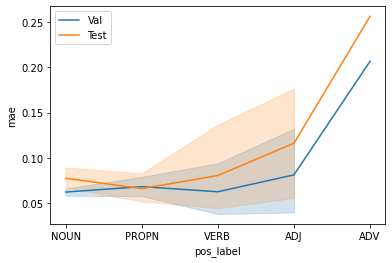

Window size of: 2


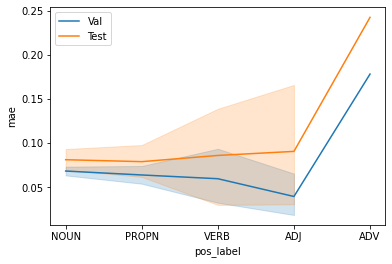

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for window_ix in results_window:
    print('Window size of:', window_ix)
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'val')], 
                    ci=98, 
                    markers='o')
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'test')], 
                    ci=98, 
                    markers='o')
    plt.legend(['Val', 'Test'])
    plt.show()